In [ ]:
import pandas as pd
import torch
from tqdm.notebook import trange
import re

In [ ]:
if torch.cuda.is_available():
  print('gpu')
else:
  print('no gpu')

gpu


In [ ]:
train_df = pd.read_csv('/content/imports.csv', sep='\t')

In [ ]:
train_df.shape

(7383, 1)

In [ ]:
train_df = train_df[:7000]

In [ ]:
train_df.shape

(7000, 1)

In [ ]:
code = ''
for i in range(len(train_df)):
  code += train_df.loc[i, 'code']

In [ ]:
tokens = re.findall(r'\S+|\n', code)

In [ ]:
tokens = list(dict.fromkeys(tokens))

In [ ]:
trigrams = [([tokens[i], tokens[i + 1]], tokens[i + 2])
            for i in range(len(tokens) - 2)]

In [ ]:
grams = len(trigrams)
print(trigrams[:3])

[(['import', 'pandas'], 'as'), (['pandas', 'as'], 'pd'), (['as', 'pd'], '\n')]


In [ ]:
vocab = set(tokens)
voc_len = len(vocab)
word_to_id = {word: i for i, word in enumerate(vocab)}

In [ ]:
context = []
target = []

for con, tar in trigrams:
  con_id = torch.tensor([word_to_id[i] for i in con], dtype=torch.long)
  context.append(con_id)
  target.append(torch.tensor([word_to_id[tar]], dtype=torch.long))

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, context, target):
    self.context = context
    self.target = target

  def __len__(self):
    return len(self.target)

  def __getitem__(self, index):
    X = self.context[index]
    y = self.target[index]
    return y, X

In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers

    self.encoder = nn.Embedding(input_size, hidden_size)
    self.gru = nn.GRU(2 * hidden_size, hidden_size, n_layers, batch_first=True,
                                                          bidirectional=False)
    self.decoder = nn.Linear(hidden_size, output_size)

  def forward(self, inp, hidden):
    inp = self.encoder(inp.view(1, -1))
    output, hidden = self.gru(inp.view(1, 1, -1), hidden)
    output = self.decoder(output.view(1, -1))
    return output, hidden

  def init_hidden(self):
    return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
def train(inp, target, batch_size):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0
    
    for c in range(batch_size):
      output, hidden = decoder(inp[c].cuda(), hidden)
      loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / grams

In [ ]:
n_epochs = 30
hidden_size = 100
n_layers = 1
lr = 0.015
batch_size = 10000

params = {'batch_size': batch_size}

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

all_losses = []

decoder.cuda()
device = torch.device("cuda:0")
# training_set = Dataset(target, context)
# training_generator = torch.utils.data.DataLoader(training_set, **params)

for epoch in trange(n_epochs):
  # for batch_inp, batch_tar in training_generator:
  #   torch.cuda.empty_cache()
  #   batch_inp,  batch_tar = batch_inp.to(device), batch_tar.to(device)
    
  #   loss = train(batch_inp, batch_tar, batch_size)
  #   all_losses.append(loss)
  torch.cuda.empty_cache()
  # context, target = context.to(device), target.to(device)
  loss = train(context, target, batch_size)
  all_losses.append(loss)

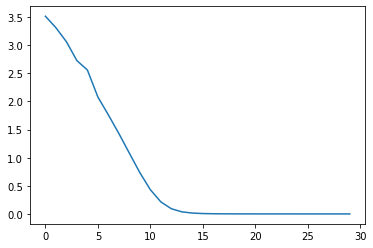

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [ ]:
def predict(prime_str='import pandas', predict_len=100, temperature=1):
    hidden = decoder.init_hidden().cuda()

    for p in trange(predict_len):
        prime_input = torch.tensor([word_to_id[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:]
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted word to string and use as next input
        predicted_word = list(word_to_id.keys())[list(word_to_id.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [ ]:
print(predict(predict_len = 10000))